In [1]:
import os
import numpy as np
import pandas as pd
# Не сворачивать колонки в датафрейме
pd.options.display.max_columns = 50
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
FILE_PATH = '/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/'

### Снижение размерности

Очень часто в анализе данных встречается ситуация, когда объект описан большим числом признаков, но при этом, в этом большимерном пространтсве объекты лежат в какой-то маломерном подпространстве (картинка ниже). Тогда объекты можно описать меньшим числом признаков, главная задача - как выбрать эти признаки и какое должно быть их число, чтобы описание объектов "не сильно пострадало".

На картинке ниже каждый объекты $x_{1}, \dots, x_{n}$ описываются 3 координатами, однако все объекты лежат на плоскости $L = span\{\vec a_{1}, \vec a_{2} \}$ : (p, q, 2p-3q), поэтому для описания этих объектов достаточно знать 2 значения: p и q. С точки зрения линейной алгебры это означает, что мы можем описать наши объекты через базис плоскости L, то есть $x_{i} = \alpha_{1} \cdot \vec a_{1} + \alpha_{2} \cdot \vec a_{2}$ и тогда координатами объекта $x_{i}$ в базисе плоскости L можно назвать $x_{i, L} = (\alpha_{1}, \alpha_{2})$

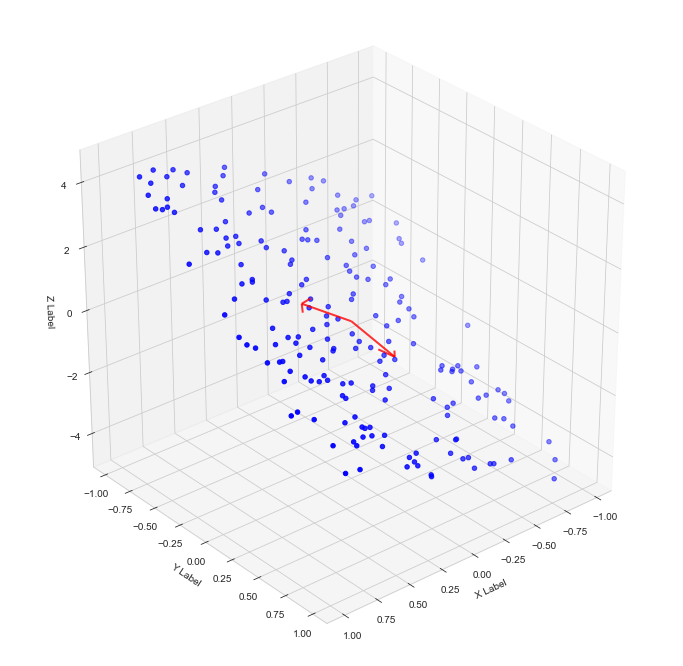

In [345]:
N = 200
x = np.random.uniform(-1, 1, size=N)
y = np.random.uniform(-1, 1, size=N)
z = 2*x - 3*y
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue')
ax.quiver(0, 0, 0, -0.15595302 - 0, 0.21722557 - 0, -0.96 - 0, color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, 0.83 - 0, 0.55 - 0, 3 - 0, color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.1)
ax.view_init(30, 50)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label');

Алгоритм, позволяющий найти это малоразмерное (линейное) описание называется [Метод главных компонент](https://ru.wikipedia.org/wiki/Метод_главных_компонент) (PCA):

${\bf Алгоритм:}$

1) Центрируем данные $\left( x_{i}' = \frac{x_{i} - mean(x)}{\sigma(x)} \right)  \Rightarrow X_{st} = \begin{bmatrix} | & \dots & | \\ x_{1}' & \dots & x_{d}' \\ | & \dots & | \end{bmatrix}   $ .

2) Находим выборочную ковариационную матрицу $M = \frac{1}{n}X_{st}^TX_{st}$.

3) Находим её собственные векторы, отвечающие k самым большим по модулю собственным значениям.

Собственные векторы, найденные в пункте 3 это и будут главные компоненты, которые мы ищем.

Рассмотрим PCA на данных c картинки выше

In [332]:
X = np.c_[x, y, 2*x - 3*y]
X_st = (X - X.mean(axis=0))/X.std(axis=0)
M = (1/X_st.shape[0])*X_st.T.dot(X_st)
eigvals, eigvecs = np.linalg.eig(M)
eigvecs = eigvecs[np.argsort(eigvals)[::-1]]
eigvals = np.sort(eigvals)[::-1]

Вектор собственных значений главных компонент

In [337]:
eigvals

array([1.98444539, 1.01555461, 0.        ])

Матрица из главных компонент

In [336]:
eigvecs

array([[-0.7043156 , -0.00646535,  0.70985755],
       [-0.58740338, -0.55619294, -0.58788322],
       [ 0.39861863, -0.83102805,  0.38793759]])

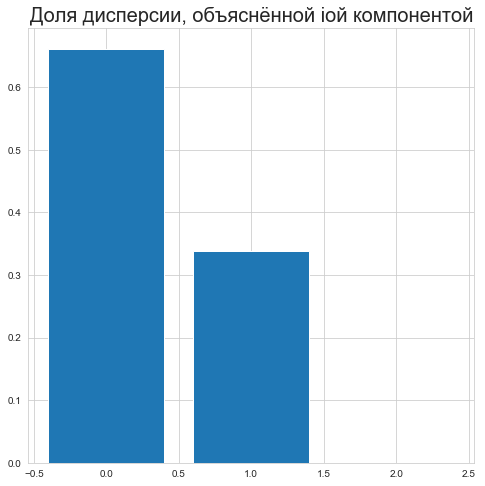

In [338]:
plt.bar(np.arange(3), eigvals/eigvals.sum());
plt.title('Доля дисперсии, объяснённой iой компонентой', fontsize=20);

Видим, что уже 2 главные компоненты описывают 100% дисперсии исходной выборки, а значит третий признак излишен.

Полученные главные компоненты всегда ортогональны друг другу (скалярное произведение равно 0). Ввиду этого свойства PCA так же применяют не только для снижения размерности, но и так же для [декорреляции признаков](https://en.wikipedia.org/wiki/Whitening_transformation).

Координаты главной компоненты означают, с какими весами исходные признаки входят в эту главную компоненту. Например comp1 = [-0.71,  -0.59, 0.39] означает, что $comp1 = -0.71 \cdot x - 0.59 \cdot y + 0.39 \cdot z$

При этом встаёт вопрос, как будут описываться иходные объекты через полученные главные компоненты. 

Обозначим исходные (стандартизованные) объекты за $x^{st}_{1}, \dots, x^{st}_{n} \quad x^{st}_{i} \in \mathbb{R}^d$. Обозначим главные компоненты за $u_{1}, \dots, u_{k} \quad u_{j} \in \mathbb{R}^d$ и матрицу из главных компонент за $U = \begin{bmatrix} | & \dots & |\\ u_{1} & \dots & u_{k} \\ | & \dots & | \end{bmatrix}, \ U \in \mathbb{R}^{d \times k}$. Тогда найти координаты исходного объекта $x^{st}_{i}$ в пространстве главных компонент можно по формуле: $x_{i}^{pc} = U^T \cdot x^{st}_{i}, $ где $x_{i}^{pc} \in \mathbb{R}^k$. Чтобы найти координаты всех объектов $X^{st} = \begin{bmatrix} - & x^{st}_{1} & - \\ \vdots & \vdots & \vdots \\ - & x^{st}_{n} & - \end{bmatrix}$ нужно перемножить $X^{st} \cdot U$

In [352]:
X_pc = X_st.dot(eigvecs[:, :2])
X_pc.shape

(200, 2)

Посмотрим на положение конкретного объекта в исходном и в новом пространствах

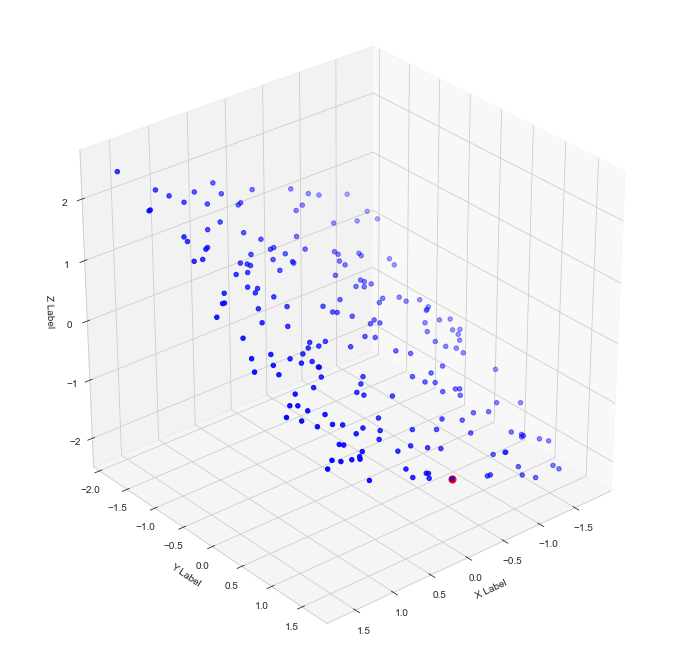

In [356]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_st[:, 0], X_st[:, 1], X_st[:, 2], color='blue')
ax.scatter(X_st[0, 0], X_st[0, 1], X_st[0, 2], color='red', s=50)
ax.view_init(30, 50)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label');

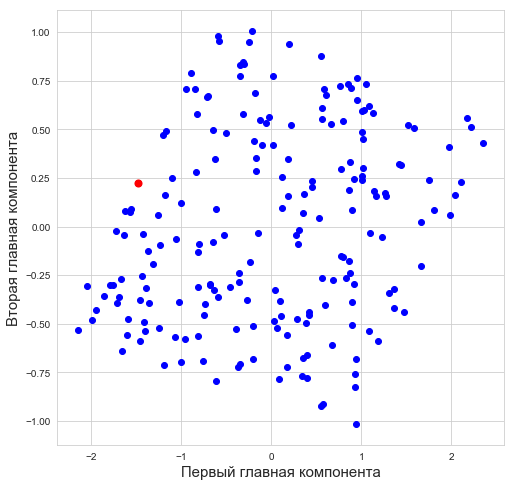

In [403]:
plt.scatter(X_pc[:, 0], X_pc[:, 1], color='blue')
plt.scatter(X_pc[0, 0], X_pc[0, 1], color='red', s=50);
plt.xlabel('Первый главная компонента', fontsize=15);
plt.ylabel('Вторая главная компонента', fontsize=15);

C использование sklearn

In [367]:
from sklearn.decomposition import PCA

In [397]:
pc = PCA(n_components=2).fit(X_st)
X_pc1 = pc.transform(X_st)

В данном случае матрица pc.components_ = $U^T$

In [400]:
pc.components_.T

array([[ 0.38793759, -0.83102805],
       [-0.58788322, -0.55619294],
       [ 0.70985755, -0.00646535]])

Полученное подпространство совпадает с найденным выше (хотя сама проекция отличается)

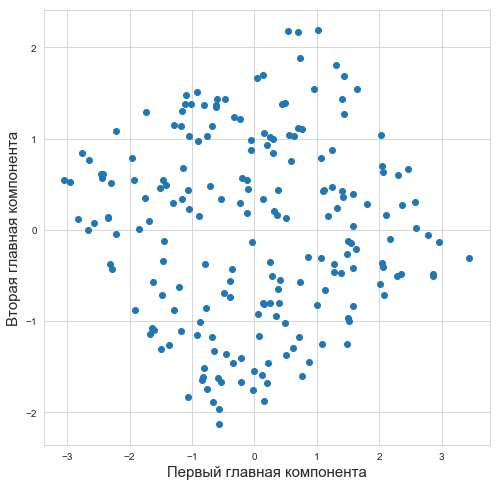

In [405]:
plt.scatter(X_pc1[:, 0], X_pc1[:, 1]);
plt.xlabel('Первый главная компонента', fontsize=15);
plt.ylabel('Вторая главная компонента', fontsize=15);

Для визуализации главных компонент полезно пользоваться диаграммой Хинтона - [Hinton Diagram](https://matplotlib.org/3.1.0/gallery/specialty_plots/hinton_demo.html) (когда много признаков лучше использовать sns.heatmap).

In [326]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
    ax.set_xlabel('Компоненты', fontsize=15);
    ax.set_ylabel('Признаки', fontsize=15);
    ax.autoscale_view()
    ax.invert_yaxis()

### Применение PCA на реальных данных

https://archive.ics.uci.edu/ml/datasets/Turkiye%2BStudent%2BEvaluation

In [334]:
dat = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/turkiye-student-evaluation_R_Specific.csv')
dat.columns = [col.replace('.', '_').lower().strip() for col in dat.columns]

Сделаем из переменной difficulty бинарную переменную, из которой возьмём крайние значения сложности курса

In [335]:
def func1(x):
    if x == 1:
        return 0
    elif (2 <= x <= 4):
        return -1
    else:
        return 1

dat['binary_difficulty1'] = dat.difficulty.apply(lambda x: func1(x))
dat = dat.loc[dat.binary_difficulty1 != -1]

In [336]:
dat.head()

,instr,class,nb_repeat,attendance,difficulty,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22,q23,q24,q25,q26,q27,q28,binary_difficulty1
5,1,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
22,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
39,1,2,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
50,1,2,1,1,5,4,4,4,4,4,4,4,4,3,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1
56,1,2,1,1,1,1,1,1,1,1,1,1,5,1,1,1,5,5,5,5,5,5,4,5,5,5,5,5,5,5,4,5,5,0


Выберем все переменные кроме целевой (difficulty и binary_difficulty) и нормируем данные

In [337]:
X_min_max = dat.apply(lambda x: (x - x.min())/(x.max() - x.min()))[dat.columns.difference(['difficulty', 'binary_difficulty1'])]
X_st = dat.apply(lambda x: (x - x.mean())/(x.std()))[dat.columns.difference(['difficulty', 'binary_difficulty1'])]

In [338]:
from sklearn.decomposition import PCA
pc = PCA(n_components=None).fit(X_st)
X_st_pc = pc.transform(X_st)

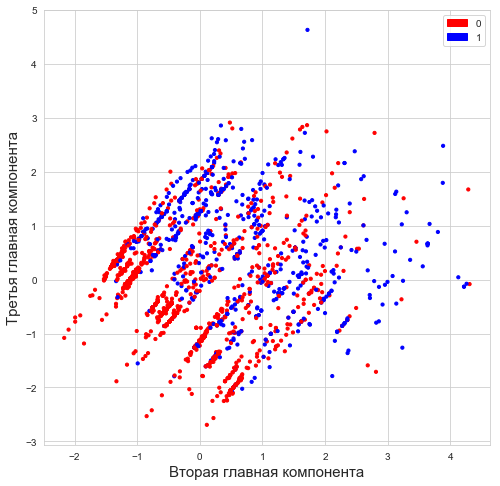

In [339]:
colors = np.array(['red', 'blue', 'yellow', 'limegreen', 'orange', 'purple', 'brown'])
categories = dat.binary_difficulty1.values
uniq_categories = np.unique(categories)
plt.scatter(X_st_pc[:, 1], X_st_pc[:, 2], 
            color=colors[categories], 
            s=10);
plt.legend(handles=[mpatches.Patch(color='{}'.format(colors[i]), label='{}'.format(uniq_categories[i])) for i in range(len(uniq_categories))])
plt.xlabel('Вторая главная компонента', fontsize=15);
plt.ylabel('Третья главная компонента', fontsize=15);

Интерпретация полученных главных компонент

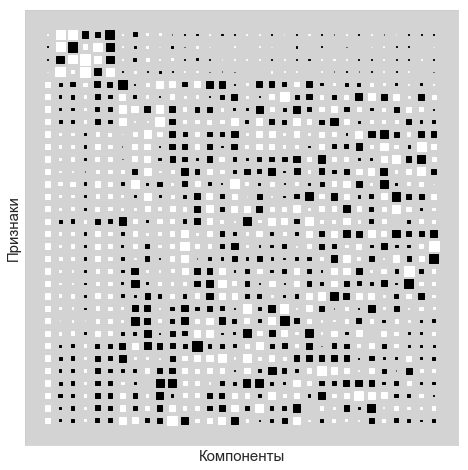

In [340]:
hinton(pc.components_)

Первая главная компонента отвечает за результаты ответов на вопросы q1 - q28. Вторая и третья главные компоненты отвечают за то, как студент посещал курс и выполнял задания.

Посмотрим на качество классификации на полном наборе данных и на наборе данных из 3 главных компонент

In [366]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [371]:
rf_full = RandomForestClassifier(n_estimators=100)
rf_full.fit(X_st.values, dat.binary_difficulty1)

k = 3
rf_pc = RandomForestClassifier(n_estimators=100)
rf_pc.fit(X_st_pc[:, :k], dat.binary_difficulty1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [372]:
print('Качество на полном наборе:', f1_score(y_true=dat.binary_difficulty1, y_pred=rf_full.predict(X_st.values)))
print("Качество на 3 главных компонентах:", f1_score(y_true=dat.binary_difficulty1, y_pred=rf_pc.predict(X_st_pc[:, :k])))

Качество на полном наборе: 0.8939157566302652
Качество на 3 главных компонентах: 0.8942457231726284


### Кластеризация

Задача кластеризация это задача разделения объектов на множества (кластеры), которые обладают следующим свойством - объекты внутри одного кластера должны быть "похожи" друг на друга, а объекты из разных кластеров должны "отличаться" друг от друга.

В неформальном определении кластера фигурируют слова <strong><i>похожи</i></strong> и <strong><i>непохожи</i></strong>. В понимании этих неформальных определений кроется ключ к построению различных алгоритмов кластеризации. Однако, так или иначе "похожесть" объектов тесно связана с расстоянием между этими объектами.

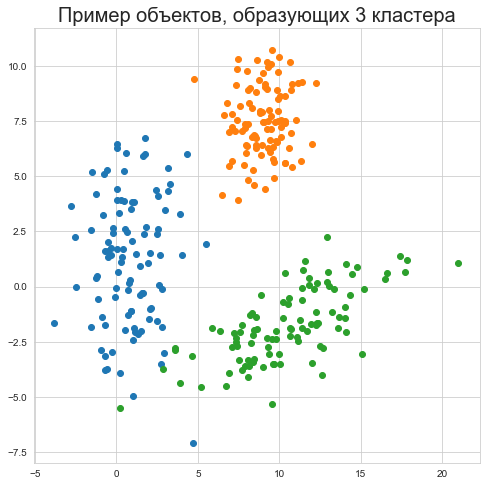

In [323]:
x1 = np.random.multivariate_normal(mean=[1, 1], cov=np.array([[3, 0], [0, 10]]), size=100)
x2 = np.random.multivariate_normal(mean=[9, 8], cov=np.array([[2, 0], [0, 3]]), size=100)
x3 = np.random.multivariate_normal(mean=[10, -2], cov=np.array([[10, 3], [3, 2]]), size=100)
X = np.r_[x1, x2, x3]

plt.scatter(x1[:, 0], x1[:, 1]);
plt.scatter(x2[:, 0], x2[:, 1]);
plt.scatter(x3[:, 0], x3[:, 1]);
plt.title('Пример объектов, образующих 3 кластера', fontsize=20);

Одним из самых известных и старых алгоритмов кластеризации является <font color='limegreen'>K-Means</font> (Методы k средних). Рассмотрим пример его работы.

<b>Алгоритм KMeans</b>:

1) Случайно инициализируем центры k кластеров ($c_{i}, \ i = 1, \dots, k$)

2) Относим к классу i все объекты, которые ближе всего к i-ому центру ($c_{i}$)

3) Пересчитываем центры кластеров как $c_{i} = \frac{1}{|A_{i}|} \sum\limits_{x \in A_{i}}x \ $ (Где: $A_{i}$ - множество всех объектов, которые принадлежат к i-ому кластеру, $|A_{i}|$ - мощность этого множества) (По факту, $c_{i}$ - среднее значение координат точек i-ого кластера)

Шаги 2-3 повторяем до выполнения условия сходимости (например, когда центры кластеров перестанут сильно меняться).

Посмотрим на итерации kmeans на примере данных выше

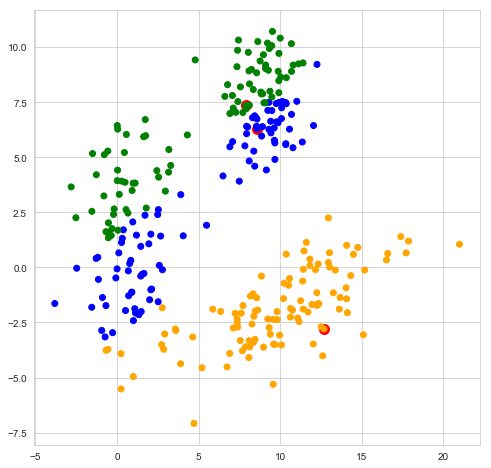

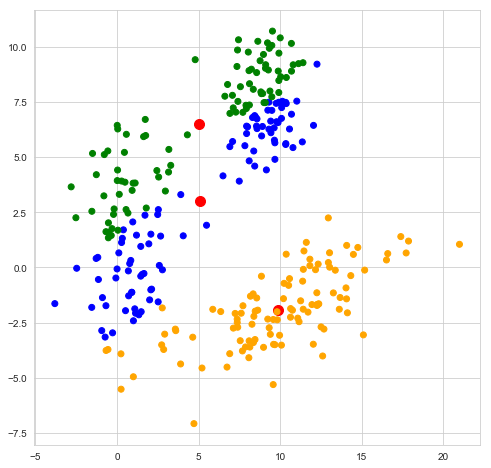

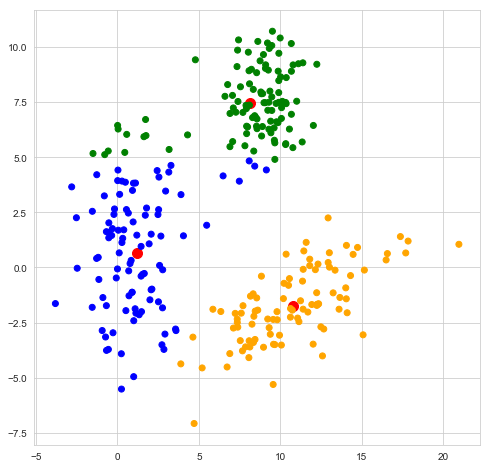

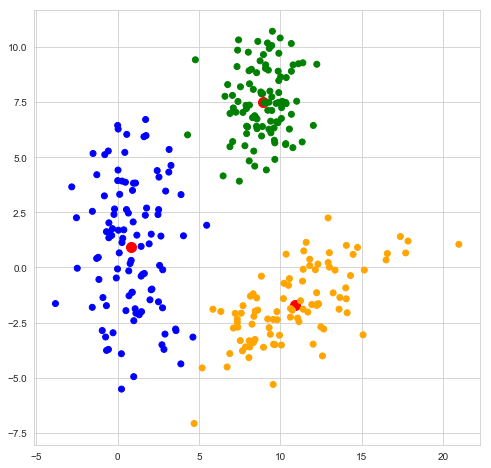

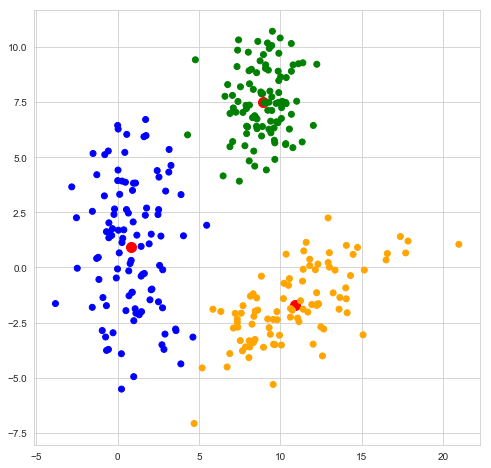

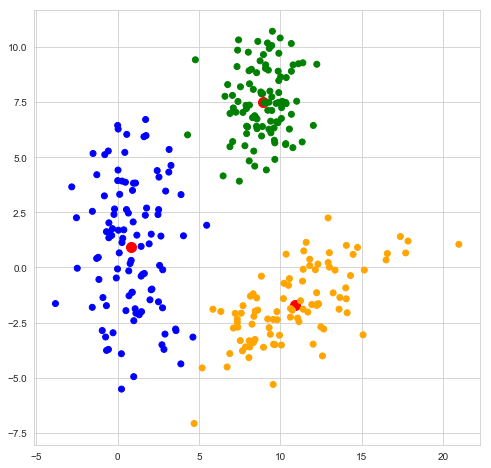

In [349]:
cluster_centers = X[np.random.choice(np.arange(X.shape[0]), size=3)]
previous_centers = cluster_centers
centers_distance_change = []
cluster_labels = np.argsort(scipy.spatial.distance.cdist(cluster_centers, X), axis=0)[0]
plt.figure(figsize=(8, 8))
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', s=100)
plt.scatter(X[:, 0], X[:, 1], c=np.array(['green', 'blue', 'orange'])[cluster_labels]);

for i in range(5):
    # отнесение объектов по кластерам
    cluster_labels = np.argsort(scipy.spatial.distance.cdist(cluster_centers, X), axis=0)[0]
    # пересчёт центров кластеров
    cluster_centers = []
    for j in range(3):
        cluster_centers.append(X[cluster_labels == j].mean(axis=0))
    cluster_centers = np.array(cluster_centers)
    centers_distance_change.append(((cluster_centers - previous_centers)**2).sum(axis=1).mean())
    previous_centers = cluster_centers
    plt.figure(figsize=(8, 8))
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', s=100)
    plt.scatter(X[:, 0], X[:, 1], c=np.array(['green', 'blue', 'orange'])[cluster_labels]);


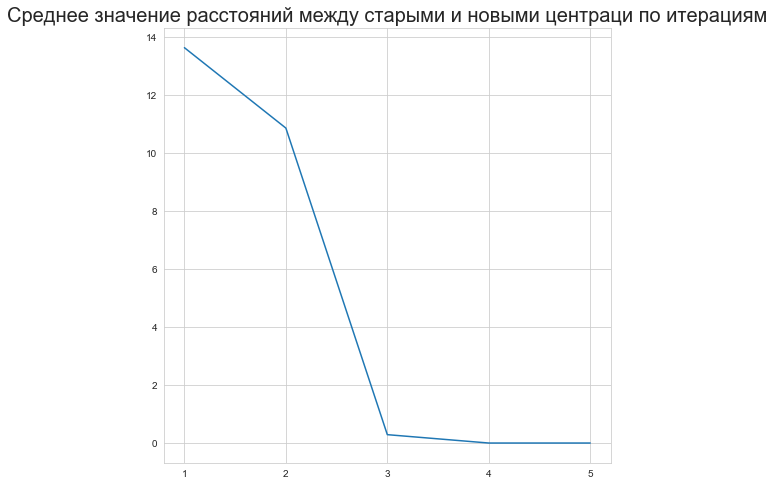

In [354]:
plt.plot(range(5), centers_distance_change);
plt.xticks(range(5), range(1, 5+1))
plt.title('Среднее значение расстояний между старыми и новыми центраци по итерациям', fontsize=20);

### Сегментация покупателей

In [4]:
aisles = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
orders = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
prior = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/order_products__prior.csv')               
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
prior = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/order_products__prior.csv')               
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
products = pd.read_csv('/Users/anton.andreytsev/Empirical-Statistics-EF-MSU-2019/data/market_basket_analysis/instacart-market-basket-analysis/products.csv')               
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [10]:
%%time
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
dat = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
# рассмотрим только юзеров с историей больше 1500 покупок
needed_users = dat.user_id.value_counts().keys()[dat.user_id.value_counts() >= 1300].values
dat = dat.loc[dat.user_id.isin(needed_users)]

Wall time: 2min 19s


Составим матрицу (покупатель х товар) и произведём tf-idf трансформацию этой матрицы

In [11]:
%%time
from sklearn.feature_extraction.text import TfidfTransformer
user_product = pd.crosstab(dat.user_id, dat.aisle)
tfidf = TfidfTransformer()
tfidf.fit(user_product.values)
user_product = pd.DataFrame(tfidf.transform(user_product.values).toarray(), columns=user_product.columns)

Wall time: 5.36 s


In [12]:
user_product.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,...,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0.0,0.019403,0.0,0.0,0.018645,0.000000,0.019394,0.000000,0.000000,0.000000,0.000000,0.002410,0.000000,0.000000,0.000000,0.000000,0.070877,0.023460,0.000000,0.000000,0.013817,0.104695,0.000000,0.0,0.059333,...,0.00000,0.002666,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.007997,0.000000,0.021228,0.000000,0.004957,0.000000,0.037552,0.000000,0.393114,0.037596,0.0,0.000000,0.000000,0.048926,0.000000,0.221710
1,0.0,0.008958,0.0,0.0,0.003443,0.010036,0.062681,0.008657,0.010393,0.000000,0.025068,0.008902,0.004037,0.000000,0.000000,0.000000,0.004909,0.000000,0.063703,0.029218,0.040829,0.049610,0.015182,0.0,0.046452,...,0.00000,0.062769,0.0,0.007889,0.000000,0.0,0.0,0.000000,0.029749,0.008615,0.016814,0.003267,0.000000,0.009155,0.000000,0.003251,0.016763,0.000000,0.002671,0.0,0.000000,0.021394,0.001255,0.000000,0.078340
2,0.0,0.038391,0.0,0.0,0.215980,0.000000,0.067155,0.017707,0.000000,0.023631,0.008545,0.245799,0.047702,0.043338,0.000000,0.000000,0.089244,0.062362,0.007239,0.037497,0.034796,0.159578,0.000000,0.0,0.042227,...,0.53436,0.110764,0.0,0.000000,0.000000,0.0,0.0,0.009091,0.000000,0.073842,0.033627,0.004455,0.025897,0.024967,0.013108,0.008866,0.000000,0.005380,0.065546,0.0,0.006757,0.000000,0.000000,0.297305,0.296255
3,0.0,0.053931,0.0,0.0,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.250090,0.041581,0.006378,0.048925,0.000000,0.022984,0.010144,0.126771,0.004829,0.003585,0.110787,0.000000,0.0,0.063578,...,0.00000,0.000000,0.0,0.026596,0.040945,0.0,0.0,0.000000,0.000000,0.034578,0.069284,0.000000,0.000000,0.022505,0.000000,0.027399,0.014491,0.000000,0.127546,0.0,0.006960,0.000000,0.014103,0.000000,0.275849
4,0.0,0.031697,0.0,0.0,0.013121,0.000000,0.059711,0.000000,0.006600,0.000000,0.000000,0.171719,0.002563,0.000000,0.000000,0.021368,0.015587,0.016051,0.091027,0.000000,0.131267,0.067860,0.012396,0.0,0.056731,...,0.00000,0.009380,0.0,0.003006,0.000000,0.0,0.0,0.003175,0.000000,0.091450,0.083291,0.037346,0.000000,0.100292,0.000000,0.082582,0.017197,0.000000,0.035616,0.0,0.000000,0.006793,0.000000,0.000000,0.009950


Визуализируем получившуюся матрицу

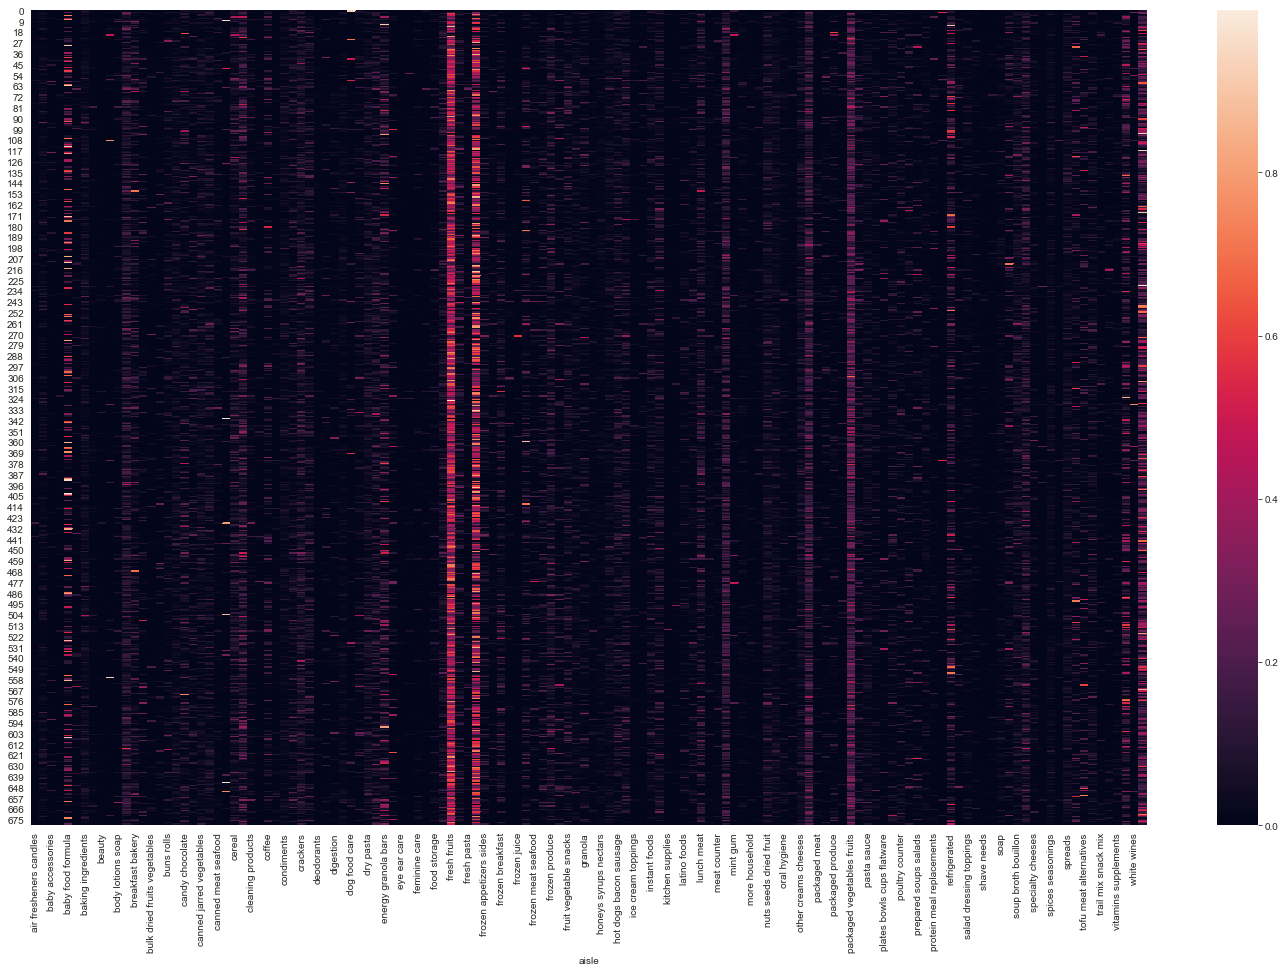

In [13]:
plt.figure(figsize=(25, 15))
sns.heatmap(user_product);

Найдём главные компоненты

In [14]:
%%time
from sklearn.decomposition import PCA
pc = PCA(n_components=None).fit(user_product)
X_pc = pc.transform(user_product)

Wall time: 1.04 s


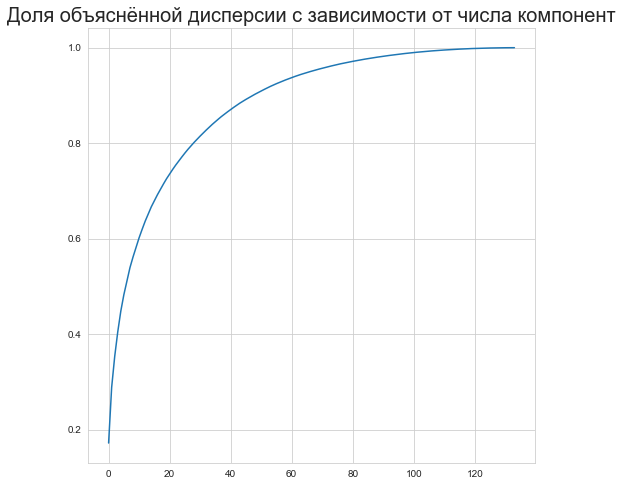

In [15]:
plt.plot(pc.explained_variance_ratio_.cumsum());
plt.title('Доля объяснённой дисперсии с зависимости от числа компонент', fontsize=20);

Визуализация главных компонент

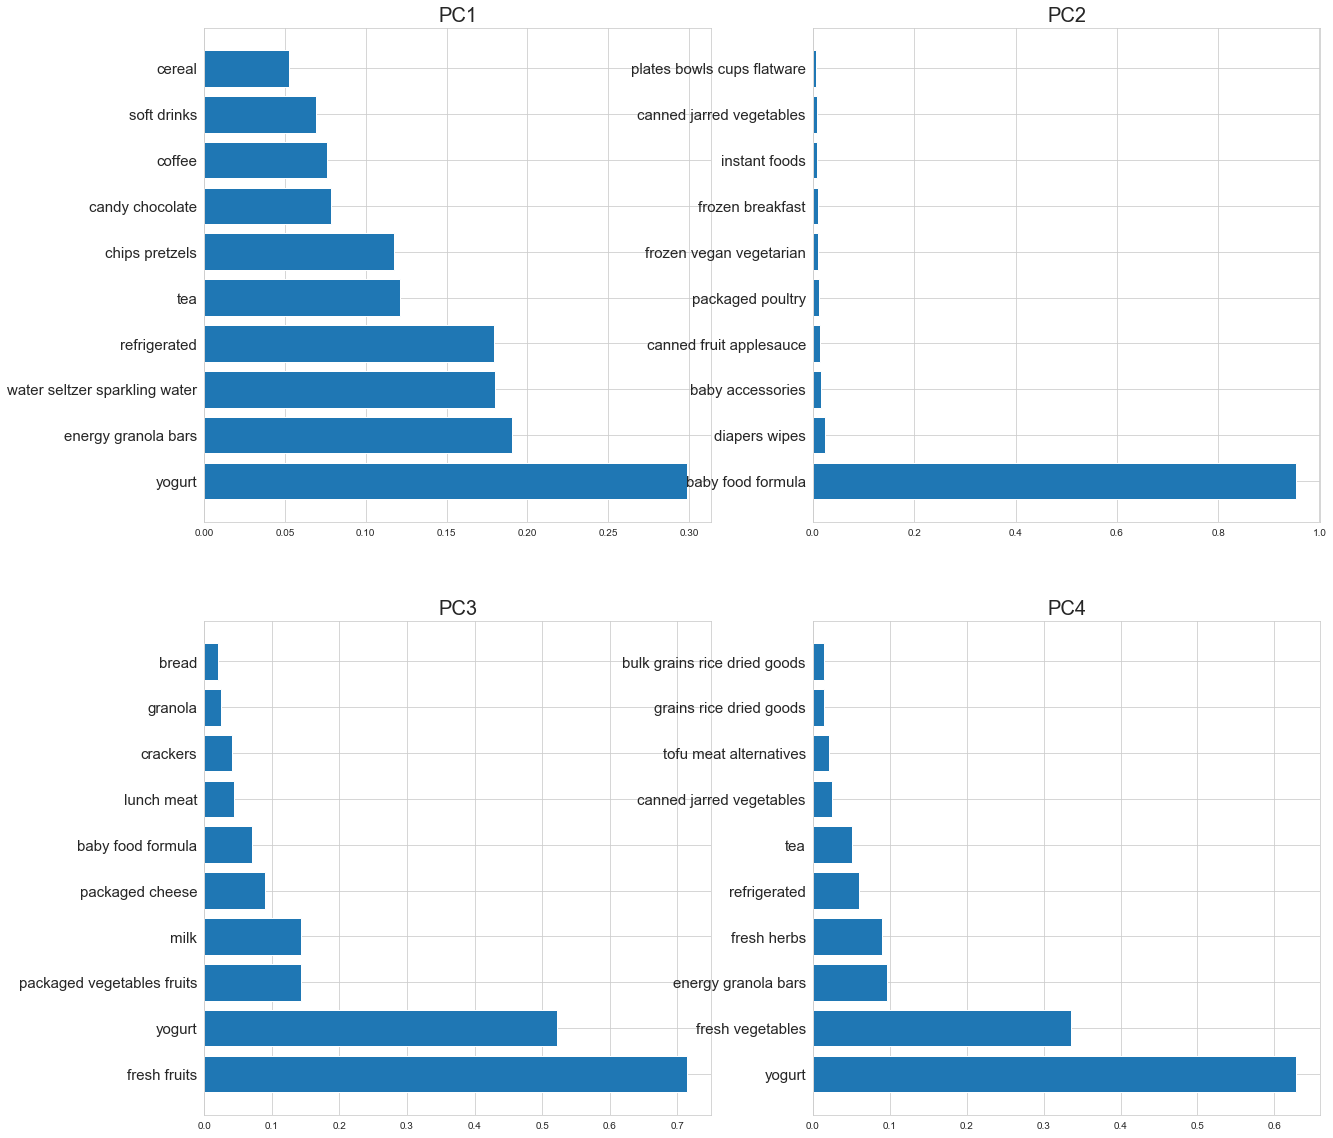

In [16]:
import itertools
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20));
for k, (i, j) in enumerate(itertools.product([0, 1], [0, 1])):
    ax[i, j].barh(user_product.columns.values[np.argsort(pc.components_[k])[::-1]][:10], np.sort(pc.components_[k])[::-1][:10])
    ax[i, j].set_title('PC{}'.format(k+1), fontsize=20);
    plt.sca(ax[i, j])
    plt.yticks(fontsize=15);

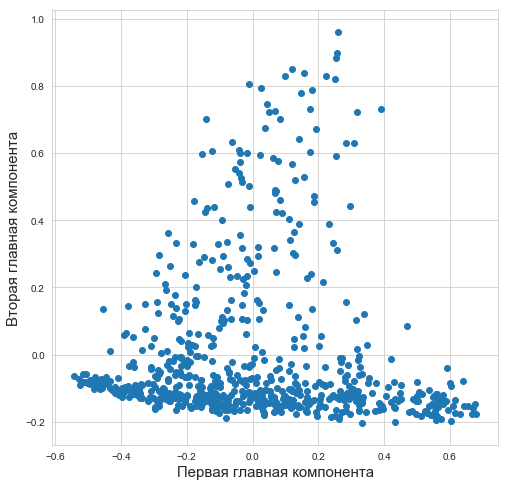

In [20]:
plt.scatter(X_pc[:, 0], X_pc[:, 1]);
plt.xlabel('Первая главная компонента', fontsize=15);
plt.ylabel('Вторая главная компонента', fontsize=15);

Уже по смыслу первых двух компонент, можно отедить покупателей, имеющих детей

In [21]:
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.manifold import TSNE

Составим кластера по 5 первым главным компонентам

In [22]:
%%time
clus = MiniBatchKMeans(n_clusters=5, max_iter=40)
clus.fit(X_pc[:, :5])

Wall time: 27 ms


Посмотрим на топ 10 продуктов получившихся кластеров

In [25]:
for clust in np.unique(clus.labels_)[0:]:
    print('Cluster {}:'.format(clust + 1))
    print(', '.join(user_product.loc[clus.labels_ == clust].mean(axis=0).sort_values(ascending=False)[:10].keys().values))
    print()

Cluster 1:
yogurt, fresh fruits, energy granola bars, refrigerated, water seltzer sparkling water, tea, chips pretzels, milk, packaged vegetables fruits, packaged cheese

Cluster 2:
fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, packaged cheese, milk, chips pretzels, bread, crackers, baby food formula

Cluster 3:
baby food formula, fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, packaged cheese, milk, soy lactosefree, water seltzer sparkling water, chips pretzels

Cluster 4:
fresh vegetables, fresh fruits, packaged vegetables fruits, yogurt, packaged cheese, fresh herbs, soy lactosefree, milk, bread, frozen produce

Cluster 5:
fresh fruits, fresh vegetables, chips pretzels, packaged vegetables fruits, packaged cheese, water seltzer sparkling water, yogurt, refrigerated, bread, milk



Кластеры не отличаются по наимениваниям продуктов - возможно они отличаются по количеству потребляемых продуктов

In [26]:
l = list(set(['fresh fruits', 'fresh vegetables', 'packaged vegetables fruits', 'yogurt', 'packaged cheese', 'chips pretzels', 'milk', 'bread', 'water seltzer sparkling water', 'soy lactosefree', 
'yogurt', 'fresh fruits', 'energy granola bars', 'refrigerated', 'tea', 'chips pretzels', 'milk', 'candy chocolate', 'packaged vegetables fruits', 
'fresh fruits', 'baby food formula', 'packaged cheese', 'packaged cheese', 'oils vinegars', 'frozen produce', 'canned meals beans']))

In [27]:
cluster_df = pd.DataFrame(columns=l)
for clust in np.unique(clus.labels_):
    current_cluster_df = pd.DataFrame(user_product.loc[clus.labels_ == clust, l].mean(axis=0)).T
    cluster_df = pd.concat([cluster_df, current_cluster_df/current_cluster_df.sum().sum()])
cluster_df.index = range(1, cluster_df.shape[0]+1)
cluster_df

aisle,refrigerated,packaged vegetables fruits,energy granola bars,water seltzer sparkling water,soy lactosefree,packaged cheese,baby food formula,canned meals beans,tea,frozen produce,milk,yogurt,chips pretzels,candy chocolate,fresh vegetables,fresh fruits,bread,oils vinegars
1,0.085572,0.048613,0.092114,0.084680,0.033319,0.041096,0.005399,0.003490,0.056471,0.008730,0.049863,0.205179,0.052909,0.038611,0.026239,0.142075,0.022605,0.003036
2,0.031024,0.102196,0.026276,0.031957,0.030571,0.062618,0.032805,0.016723,0.009983,0.029114,0.052750,0.080617,0.039114,0.014422,0.157331,0.232390,0.038677,0.011431
3,0.026604,0.075888,0.024310,0.027218,0.029788,0.048995,0.266799,0.013665,0.007964,0.026332,0.041473,0.072550,0.027021,0.012150,0.116919,0.146500,0.026596,0.009226
4,0.021410,0.097419,0.022824,0.028350,0.036319,0.045782,0.021407,0.026683,0.011285,0.029724,0.034952,0.048975,0.027203,0.010982,0.297205,0.187510,0.030452,0.021519
5,0.059258,0.078688,0.050312,0.074398,0.048911,0.074735,0.011346,0.013327,0.033629,0.027818,0.054712,0.065116,0.082930,0.027767,0.083341,0.144731,0.056868,0.012112


Визуализируем получившиеся кластеры

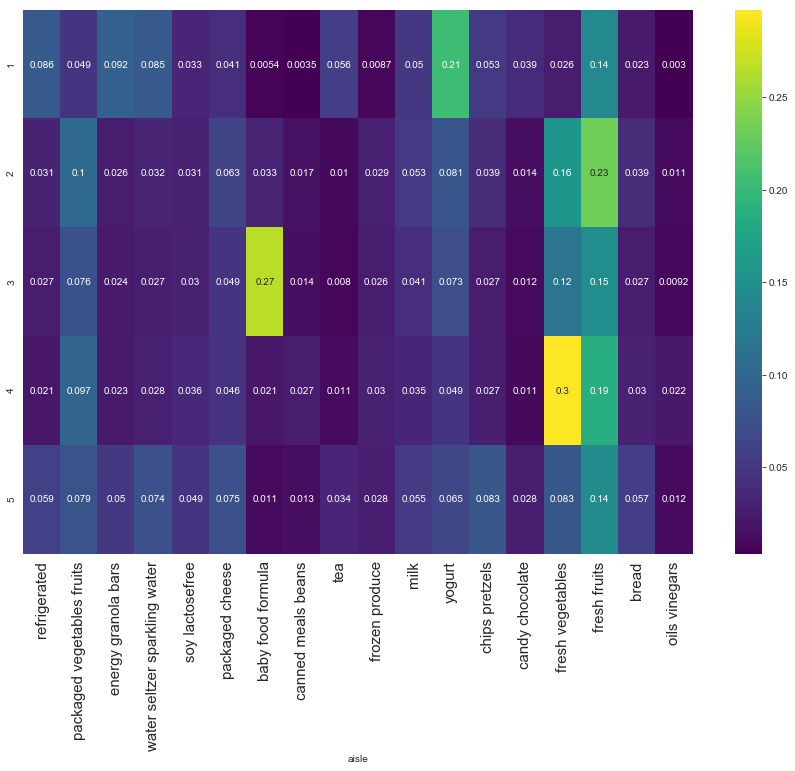

In [28]:
plt.figure(figsize=(15, 10))
sns.heatmap(cluster_df, cmap='viridis', annot=True);
plt.xticks(fontsize=15);

Кроме того, увидим, что эти кластеры так же отличаются и по потреблении товаров, которые не являются товарами первой необходимости

In [29]:
for clust in np.unique(clus.labels_)[0:]:
    print('Cluster {}:'.format(clust + 1))
    print(', '.join(user_product.loc[clus.labels_ == clust].mean(axis=0).sort_values(ascending=False)[13:23].keys().values))
    print()

Cluster 1:
fresh dips tapenades, cream, fresh vegetables, lunch meat, cereal, bread, crackers, granola, fruit vegetable snacks, soft drinks

Cluster 2:
soy lactosefree, frozen produce, eggs, energy granola bars, juice nectars, ice cream ice, hot dogs bacon sausage, frozen breakfast, cereal, dry pasta

Cluster 3:
frozen produce, energy granola bars, cereal, eggs, frozen meals, lunch meat, frozen breakfast, fresh dips tapenades, nuts seeds dried fruit, hot dogs bacon sausage

Cluster 4:
tofu meat alternatives, canned jarred vegetables, energy granola bars, baking ingredients, soup broth bouillon, nuts seeds dried fruit, dry pasta, oils vinegars, refrigerated, baby food formula

Cluster 5:
lunch meat, frozen meals, soft drinks, crackers, breakfast bakery, ice cream ice, juice nectars, tea, coffee, paper goods



In [36]:
import gensim
import pyLDAvis
import pyLDAvis.gensim as gensimvis

In [54]:
from gensim.test.utils import common_texts

In [122]:
user_product = pd.crosstab(dat.user_id, dat.aisle)
cols = user_product.columns.values

In [127]:
row = user_product.values[0]

In [132]:
cols[row != 0][0]

'asian foodsasian foodsasian foods'

In [168]:
texts = [list(itertools.chain.from_iterable([[cols[row != 0][i]]*n_times for i, n_times in enumerate(row[row != 0])])) for row in user_product.values]
texts = [' '.join(text).split() for text in texts]

In [188]:
id2word = gensim.corpora.Dictionary([text for text in texts])
corpus = [id2word.doc2bow(text) for text in texts]

In [206]:
%%time
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=10, per_word_topics=True)
# lda.save('eva_lda_2.model')

Wall time: 30.4 s


In [194]:
vis_data = gensimvis.prepare(lda, corpus, id2word)

In [195]:
pyLDAvis.display(vis_data)

In [207]:
n_topics = lda.num_topics
def get_lda_document_topics(corpus, model, n_topics):
    doc_topics_matrix = np.zeros((len(corpus), n_topics))
    for n, j in enumerate(corpus):
        a = model.get_document_topics(j, minimum_probability=0)
        doc_topics_matrix[n] = [i[1] for i in a]
    return doc_topics_matrix


def topics_representation_via_documents(corp, pd_t, n_topics=None, topics=None, n_documents=20, 
                                        show_probs=True):
    a = []
    if topics is None:
        for i in range(n_topics):
            if show_probs:
                a.append(tuple([i, [(k, j) for k, j in zip(np.array(corp)[np.argsort(pd_t, axis=0)[::-1][:n_documents, i]], np.sort(pd_t, axis=0)[::-1][:n_documents, i])]]))                                
            else:
                a.append(tuple([i, [j for j in np.array(corp)[np.argsort(pd_t, axis=0)[::-1][:n_documents, i]]]]))
        
    else:
        for i in topics:
            if show_probs:
                a.append(tuple([i, [(k, j) for k, j in zip(np.array(corp)[np.argsort(pd_t, axis=0)[::-1][:n_documents, i]], np.sort(pd_t, axis=0)[::-1][:n_documents, i])]]))                                
            else:
                a.append(tuple([i, [j for j in np.array(corp)[np.argsort(pd_t, axis=0)[::-1][:n_documents, i]]]]))
    return a

In [214]:
pt_d = get_lda_document_topics(corpus, model=lda, n_topics=n_topics)
pd_t = (pt_d/pt_d.sum(axis=0))
a = topics_representation_via_documents(corp=texts, n_documents=3, pd_t=pd_t, show_probs=False, 
                                        n_topics=lda.num_topics)

In [230]:
' '.join(a[2][1][0])

'asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods asian foods baking ingredients baking ingredients baking ingredients baking ingredients baking ingredients baking ingredients bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread bread breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery breakfast bakery break